In [55]:
import json
import numpy as np
import sklearn
import sklearn.metrics
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import datetime
filename = "mpd/data/mpd.slice.0-999.json"
filename = "mpd.slice.0-999.json"

In [2]:
with open(filename) as file:
    data = json.load(file)

In [3]:
data.keys()

dict_keys(['info', 'playlists'])

In [5]:
# Gets the number of tracks in each playlist
num_track_list = []
num_album_list = []
num_followers_list = []
# hour is not interesting
modified_at_day_list = []
modified_at_weekday_list = []
modified_at_month_list = []
modified_at_year_list = []
for i in range(len(data['playlists'])):
    plylist = data['playlists'][i]
    num_track_list.append(plylist['num_tracks'])
    num_album_list.append(plylist['num_albums'])
    num_followers_list.append(plylist['num_followers'])
    modified_at = datetime.datetime.fromtimestamp(plylist['modified_at'])
    modified_at_day_list.append(modified_at.day)
    modified_at_weekday_list.append(modified_at.weekday())
    modified_at_month_list.append(modified_at.month)
    modified_at_year_list.append(modified_at.year)

In [6]:
min(num_track_list)

5

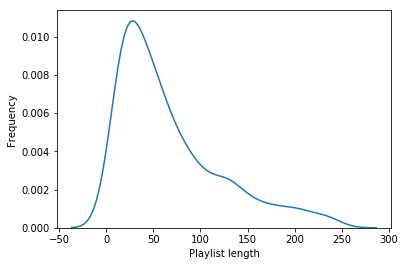

In [7]:
sns.kdeplot(num_track_list)
plt.xlabel('Playlist length')
plt.ylabel('Frequency')
plt.show()

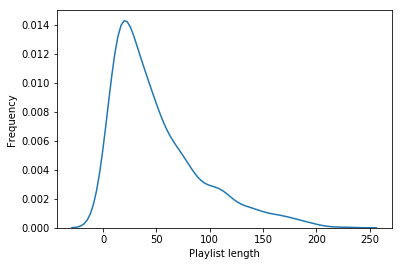

In [8]:
sns.kdeplot(num_album_list)
plt.xlabel('Playlist length')
plt.ylabel('Frequency')
plt.show()

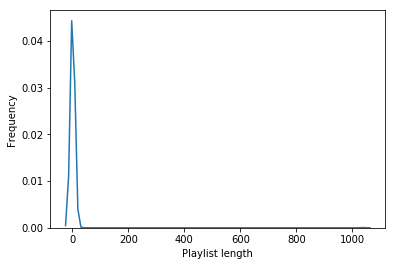

In [9]:
sns.kdeplot(num_followers_list)
plt.xlabel('Playlist length')
plt.ylabel('Frequency')
plt.show()

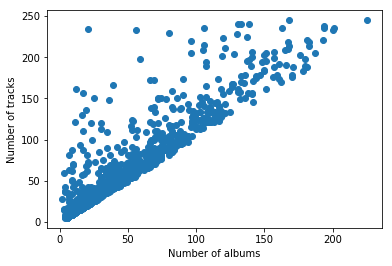

In [10]:
plt.scatter(num_album_list, num_track_list)
plt.xlabel('Number of albums')
plt.ylabel('Number of tracks')
plt.show()

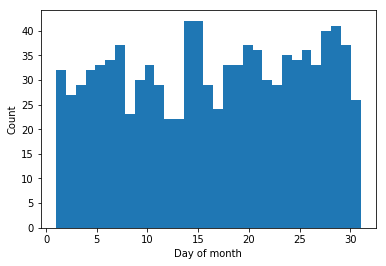

In [11]:
plt.hist(modified_at_day_list, 31)
plt.xlabel('Modified day of month')
plt.ylabel('Count')
plt.show()

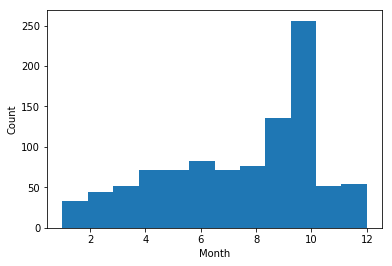

In [12]:
plt.hist(modified_at_month_list, 12)
plt.xlabel('Modified month')
plt.ylabel('Count')
plt.show()

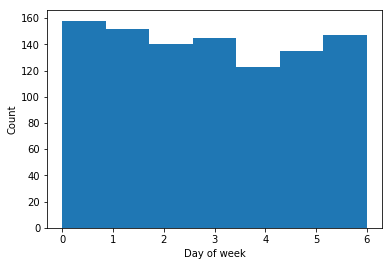

In [13]:
plt.hist(modified_at_weekday_list, 7)
plt.xlabel('Modified day of week')
plt.ylabel('Count')
plt.show()

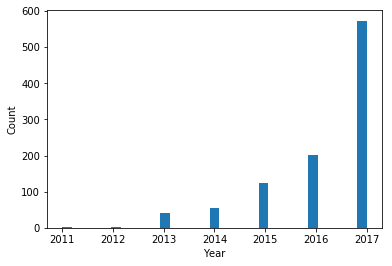

In [14]:
plt.hist(modified_at_year_list, 31)
plt.xlabel('Modified year')
plt.ylabel('Count')
plt.show()

In [18]:
song_list = set([])
duration_list = []
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        song_list.add(data['playlists'][i]['tracks'][j]['track_uri'])
        duration_list.append(data['playlists'][i]['tracks'][j]['duration_ms']/(60*1000))
song_list = list(song_list)
song_order_dict = dict(zip(song_list, range(len(song_list))))

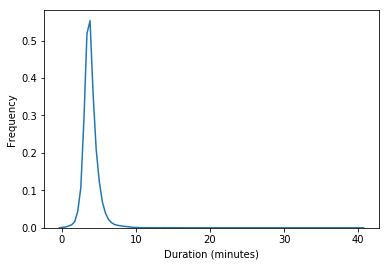

In [20]:
sns.kdeplot(duration_list)
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

In [21]:
len(song_list)

34443

In [23]:
features = np.zeros((len(data['playlists']), len(song_list)))

In [24]:
features.shape

(1000, 34443)

In [25]:
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        track_uri = data['playlists'][i]['tracks'][j]['track_uri']
        k = song_order_dict[track_uri]
        features[i][k] = 1

In [33]:
# take top 100 tracks
top_features = list(reversed(features.sum(0).argsort()))[:100]
# cosine similarity of playlists by top 100 tracks
playlist_cosine_matrix = sklearn.metrics.pairwise.cosine_similarity(features[:,top_features])
# cosine similarity of tracks by top 100 tracks
track_cosine_matrix = sklearn.metrics.pairwise.cosine_similarity(features[:,top_features].T)

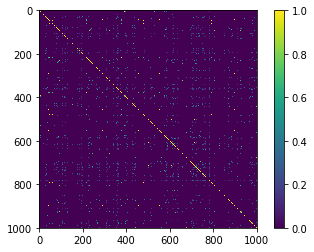

In [34]:
plt.imshow(playlist_cosine_matrix)
plt.colorbar()
plt.xlabel('Playlist')
plt.ylabel('Playlist')
plt.show()

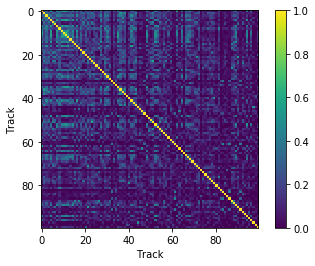

In [35]:
plt.imshow(track_cosine_matrix)
plt.colorbar()
plt.xlabel('Track')
plt.ylabel('Track')
plt.show()

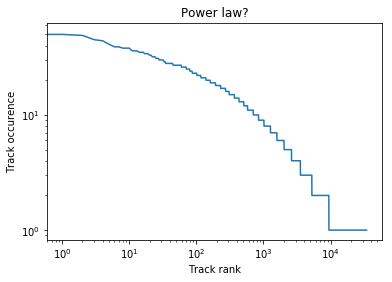

In [39]:
plt.loglog(sorted(features.sum(0), reverse=True))
plt.xlabel('Track rank')
plt.ylabel('Track occurence')
plt.title('Power law?')
plt.show()

In [40]:
artist_list = set([])
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        artist_list.add(data['playlists'][i]['tracks'][j]['artist_uri'])
artist_list = list(artist_list)
artist_order_dict = dict(zip(artist_list, range(len(artist_list))))

In [41]:
artist_features = np.zeros((len(data['playlists']), len(artist_list)))

In [42]:
for i in range(len(data['playlists'])):
    for j in range(data['playlists'][i]['num_tracks']):
        artist_uri = data['playlists'][i]['tracks'][j]['artist_uri']
        k = artist_order_dict[artist_uri]
        artist_features[i][k] = 1

In [47]:
top_artist_features = list(reversed(artist_features.sum(0).argsort()))[:100]
artist_cosine_matrix = sklearn.metrics.pairwise.cosine_similarity(artist_features[:,top_artist_features].T)

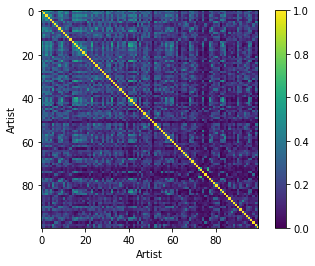

In [49]:
plt.imshow(artist_cosine_matrix)
plt.xlabel('Artist')
plt.ylabel('Artist')
plt.colorbar()
plt.show()

In [51]:
playlist_list = []
for i in range(len(data['playlists'])):
    playlist_list.append(data['playlists'][i])
    

In [53]:
playlist_names = []
for playlist in playlist_list:
    playlist_names.append(playlist['name'])

In [54]:
playlist_name_index = []
for play_list_name in playlist_names:
    playlist_name_index.append(playlist_names.index(play_list_name))


In [67]:
G = nx.Graph()
G.add_nodes_from(playlist_name_index)

In [61]:
def edgeCounter(playlist1, playlist2):
    tracks1 = get_tracks(playlist1)
    tracks2 = get_tracks(playlist2)
    common_set = tracks1.intersection(tracks2)
    edge_count = len(common_set)
    return edge_count   

In [62]:
def get_tracks(playlist):
    track_list = set([])
    for i in range(playlist['num_tracks']):
        track_list.add(playlist['tracks'][i]['track_uri'])
    return track_list

In [63]:
get_tracks(playlist_list[0])
get_tracks(playlist_list[1])
print()

In [64]:
edgeCounter(playlist_list[0], playlist_list[1])

0

In [65]:
def make_graph(G, playlist_list):
    for i in range(len(playlist_list)):
        for j in range(i+1, len(playlist_list)):
            edge_count = edgeCounter(playlist_list[i],playlist_list[j])
            if edge_count > 0:
                G.add_edge(i,j)

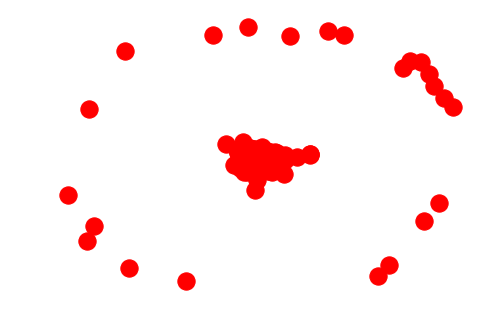

In [68]:
make_graph(G, playlist_list)
nx.draw(G)

In [69]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 997
Number of edges: 60936
Average degree: 122.2387


/Users/Pani/Documents/ucl/project/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


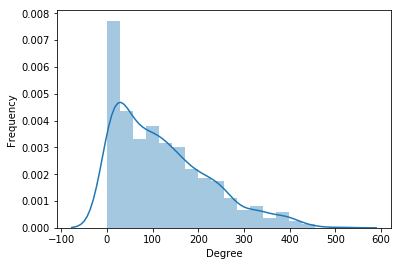

In [103]:
sns.distplot([d for n, d in G.degree()])
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.show()

In [79]:
# Number of all unique tracks
all_tracks_in_playlists = set([])
for playlist in playlist_list:
    trackList =  get_tracks(playlist)
    all_tracks_in_playlists.update(trackList)
len(all_tracks_in_playlists)

34443

In [82]:
def fast_make_graph(G, playlist_list):
    graph_list = {}
    for i in range (len(playlist_list)):
        playlist = playlist_list[i]
        for j in range(playlist['num_tracks']):
            track_uri = playlist['tracks'][j]['track_uri']
            if track_uri not in graph_list:
                graph_list[track_uri] = set()
            graph_list[track_uri].add(i)
    for track_uri, node_list in graph_list.items():
        node_list = list(node_list)
        for i in range(len(node_list)):
            for j in range(i+1, len(node_list)):
                G.add_edge(node_list[i], node_list[j])
        

In [83]:
G2 = nx.Graph()
fast_make_graph(G2, playlist_list)

In [84]:
print(nx.info(G2))

Name: 
Type: Graph
Number of nodes: 974
Number of edges: 60936
Average degree: 125.1253


In [85]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 997
Number of edges: 60936
Average degree: 122.2387


In [86]:
nodes_triangles = nx.triangles(G2)

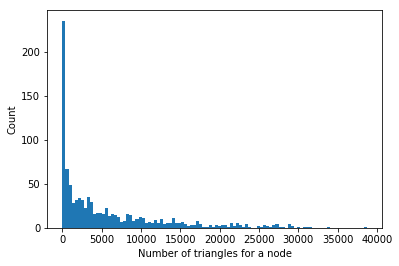

In [91]:
plt.hist(nodes_triangles.values(), 100)
plt.xlabel('Number of triangles for a node')
plt.ylabel('Count')
plt.show()

/Users/Pani/Documents/ucl/project/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


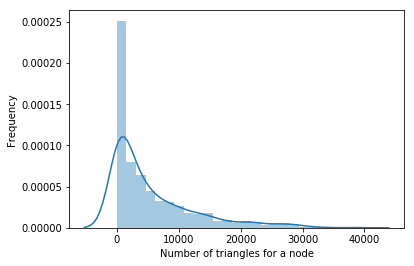

In [92]:
sns.distplot(list(nodes_triangles.values()))
plt.xlabel('Number of triangles for a node')
plt.ylabel('Frequency')
plt.show()

In [93]:
clustering_coeff = nx.clustering(G2)

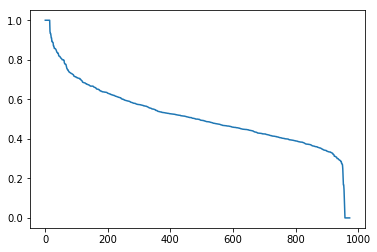

In [96]:
plt.plot(sorted(clustering_coeff.values(), reverse=True))
plt.xlabel('Node rank')
plt.ylabel('Clustering coefficient')
plt.show()

/Users/Pani/Documents/ucl/project/env/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


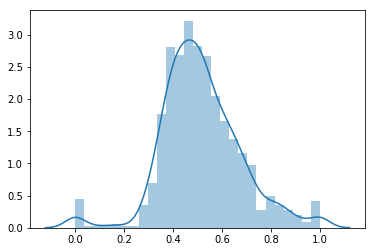

In [100]:
sns.distplot(list(clustering_coeff.values()))
plt.xlabel('Clustering coefficient')
plt.ylabel('Density')
plt.show()

In [101]:
# Average clustering coefficient:
print(nx.average_clustering(G2))

0.5153773801136027
